In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [2]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [4]:
import pandas as pd
import json
import os
from torch.utils.data import DataLoader, TensorDataset

In [5]:
# ==============================================================
# Load and stack JSON data (channel-first for PyTorch)
# ==============================================================

def load_and_stack(path):
    """Load JSON file, stack band_1 and band_2 into 2-channel tensors, and normalize to [-1, 1]."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    with open(path, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df['band_1'] = df['band_1'].apply(lambda x: np.array(x).reshape(75, 75))
    df['band_2'] = df['band_2'].apply(lambda x: np.array(x).reshape(75, 75))
    
    # Stack both bands along channel axis
    X = np.stack([np.dstack((b1, b2)) for b1, b2 in zip(df['band_1'], df['band_2'])])
    
    # Normalize each image to [-1, 1]
    X_min = X.min(axis=(1, 2, 3), keepdims=True)
    X_max = X.max(axis=(1, 2, 3), keepdims=True)
    X = 2 * (X - X_min) / (X_max - X_min + 1e-8) - 1   # small epsilon to avoid divide-by-zero

    # Move channels to first dimension for PyTorch (N, C, H, W)
    X = np.transpose(X, (0, 3, 1, 2))
    return X, df

# ==============================================================
# Paths
# ==============================================================

train_path = r"C:\Users\matan\statoil-iceberg-classifier-challenge\train.json\data\processed\train.json"
test_path = r"C:\Users\matan\statoil-iceberg-classifier-challenge\test.json\data\processed\test.json"

# ==============================================================
# Load data
# ==============================================================

X_train, df_train = load_and_stack(train_path)
y_train = np.array(df_train['is_iceberg'])
X_test, df_test = load_and_stack(test_path)

# ==============================================================
# Split and convert to tensors
# ==============================================================

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

X_train_tensor = torch.tensor(X_train_split, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_split, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_split, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_split, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# ==============================================================
# Create DataLoaders
# ==============================================================

trainloader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
testloader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=False)
inferloader = DataLoader(TensorDataset(X_test_tensor), batch_size=32, shuffle=False)


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, stride=1, padding=1),  # 32 2x2x2 (RG) filters applied to raw image set
            nn.MaxPool2d(kernel_size=2, stride=2),                                          # Pooling layer 2x2, (32,64,64) --> (32,32,32)
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # Output size = floor((W_in + 2P -K)/s) + 1
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            
        )

         # Dynamically compute the flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 2, 75, 75)
            dummy_output = self.conv(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).size(1)
            print(f"Flattened size = {self.flattened_size}")

        # Connects layers
        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, 64),  # Maps flattened images to 64-Dimensional hidden layer
            nn.ReLU(),                           # Activates non-linearity
            nn.Linear(64, 2)                     # Maps 64 features to two outputs per class
        )
    
    # Responsible for forward propagation
    def forward(self, x):
        x = self.conv(x)           # Passes images through CNN
        x = x.view(x.size(0), -1)  # Flattens each image into a 1D vector for the fully connected layer
        x = self.fc(x)             # Pass the flattened images through the fully connected layer
        return x
    
model = CNN()

# Store loss function and optimizer function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=.01)

Flattened size = 20736


In [7]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np


In [9]:
# Training loop

loss_list = []
accuracy_list = []
precision_list = []
recall_list = []

for epoch in range(60):
    model.train()
    epoch_loss = 0

    for images, labels in trainloader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(trainloader)
    loss_list.append(avg_loss)

    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)

    print(f"Epoch [{epoch+1}/50] | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

Epoch [1/50] | Loss: 0.6757 | Accuracy: 0.5576 | Precision: 0.5702 | Recall: 0.5615
Epoch [2/50] | Loss: 0.6716 | Accuracy: 0.5981 | Precision: 0.5990 | Recall: 0.5964
Epoch [3/50] | Loss: 0.6644 | Accuracy: 0.4829 | Precision: 0.4789 | Recall: 0.4912
Epoch [4/50] | Loss: 0.6603 | Accuracy: 0.4922 | Precision: 0.5179 | Recall: 0.5024
Epoch [5/50] | Loss: 0.6536 | Accuracy: 0.6106 | Precision: 0.6115 | Recall: 0.6090
Epoch [6/50] | Loss: 0.6535 | Accuracy: 0.5171 | Precision: 0.5366 | Recall: 0.5236
Epoch [7/50] | Loss: 0.6361 | Accuracy: 0.5078 | Precision: 0.5673 | Recall: 0.5172
Epoch [8/50] | Loss: 0.6289 | Accuracy: 0.4860 | Precision: 0.4787 | Recall: 0.4957
Epoch [9/50] | Loss: 0.6256 | Accuracy: 0.5607 | Precision: 0.7689 | Recall: 0.5510
Epoch [10/50] | Loss: 0.6215 | Accuracy: 0.5109 | Precision: 0.2555 | Recall: 0.5000
Epoch [11/50] | Loss: 0.6204 | Accuracy: 0.5857 | Precision: 0.5994 | Recall: 0.5892
Epoch [12/50] | Loss: 0.5925 | Accuracy: 0.6480 | Precision: 0.7215 | Reca

In [10]:
print(np.unique_counts(all_preds))
print(np.unique_counts(all_labels))

UniqueCountsResult(values=array([0, 1]), counts=array([140, 181]))
UniqueCountsResult(values=array([0, 1]), counts=array([157, 164]))


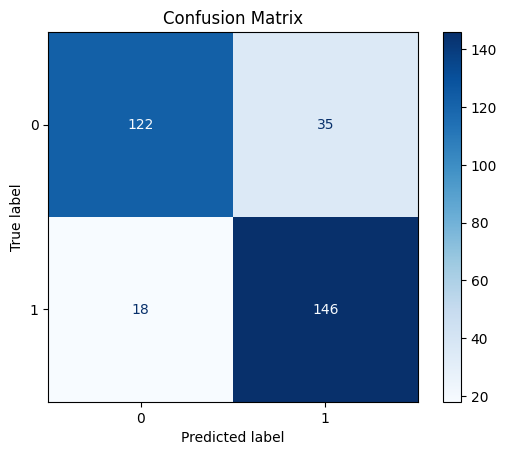

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

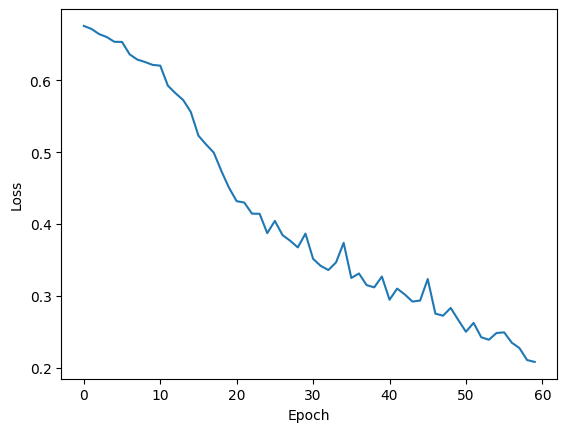

In [12]:
# Plot loss 
plt.plot(loss_list, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

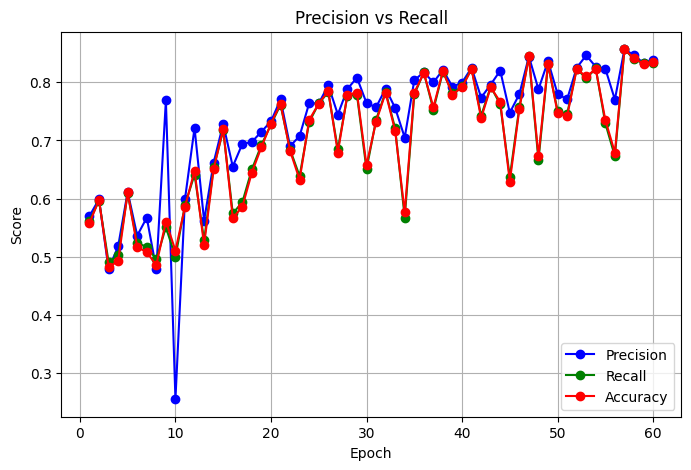

In [13]:
# Plot Precision vs Recall
plt.figure(figsize=(8,5))
plt.plot(range(1, len(precision_list)+1), precision_list, marker='o', label='Precision', color='blue')
plt.plot(range(1, len(recall_list)+1), recall_list, marker='o', label='Recall', color='green')
plt.plot(range(1, len(accuracy_list)+1), accuracy_list, marker='o', label='Accuracy', color='red')
plt.title("Precision vs Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.show()

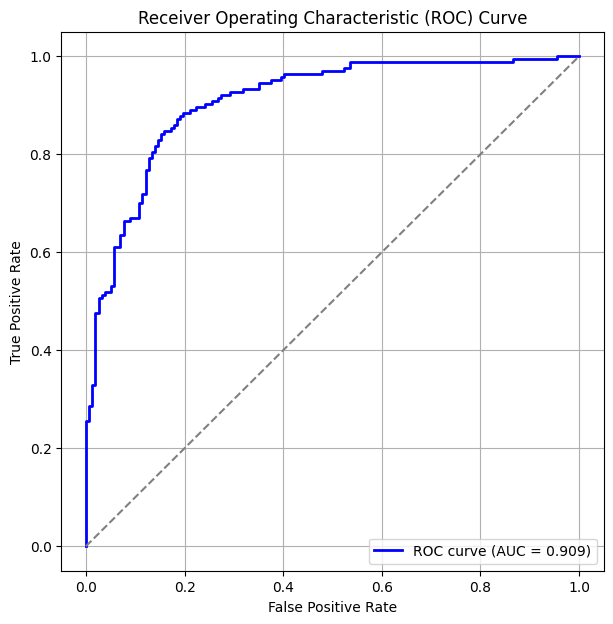

ROC-AUC Score: 0.9085


In [14]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()
all_probs, all_labels = [], []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")


In [ ]:
model.eval()
predictions = []

# Run inference on the unlabeled test set
with torch.no_grad():
    for images in inferloader:  # inferloader contains only images (no labels)
        images = images[0]  # unpack since TensorDataset wraps single tensors in a tuple
        outputs = model(images)

        # Get probability of iceberg class (class 1)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        predictions.extend(probs.cpu().numpy())

# Create submission DataFrame
submission = pd.DataFrame({
    'id': df_test['id'],
    'is_iceberg': predictions
})

# Save as CSV
submission.to_csv("submission.csv", index=False)

print("submission.csv file created successfully!")
print(submission.head())

In [6]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [7]:
# ==============================================================
# Load function (same as your original)
# ==============================================================
def load_and_stack(path):
    """Load JSON file, stack band_1 and band_2 into 2-channel tensors, and normalize to [-1, 1]."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    with open(path, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df['band_1'] = df['band_1'].apply(lambda x: np.array(x).reshape(75, 75))
    df['band_2'] = df['band_2'].apply(lambda x: np.array(x).reshape(75, 75))

    # Stack both bands along channel axis
    X = np.stack([np.dstack((b1, b2)) for b1, b2 in zip(df['band_1'], df['band_2'])])

    # Normalize each image to [-1, 1]
    X_min = X.min(axis=(1, 2, 3), keepdims=True)
    X_max = X.max(axis=(1, 2, 3), keepdims=True)
    X = 2 * (X - X_min) / (X_max - X_min + 1e-8) - 1

    # Move channels to first dimension for PyTorch (N, C, H, W)
    X = np.transpose(X, (0, 3, 1, 2))
    return X, df

In [9]:
# ==============================================================
# Load Data
# ==============================================================
train_path = r"C:\Users\matan\statoil-iceberg-classifier-challenge\train.json\data\processed\train.json"
X, df = load_and_stack(train_path)

# Labels (0 = ship, 1 = iceberg)
y = df["is_iceberg"].values

# ==============================================================
# Flatten images for PCA
# ==============================================================
# Shape (N, C, H, W) -> flatten to (N, C*H*W)
X_flat = X.reshape(X.shape[0], -1)

print("Original shape:", X.shape)
print("Flattened shape:", X_flat.shape)

Original shape: (1604, 2, 75, 75)
Flattened shape: (1604, 11250)


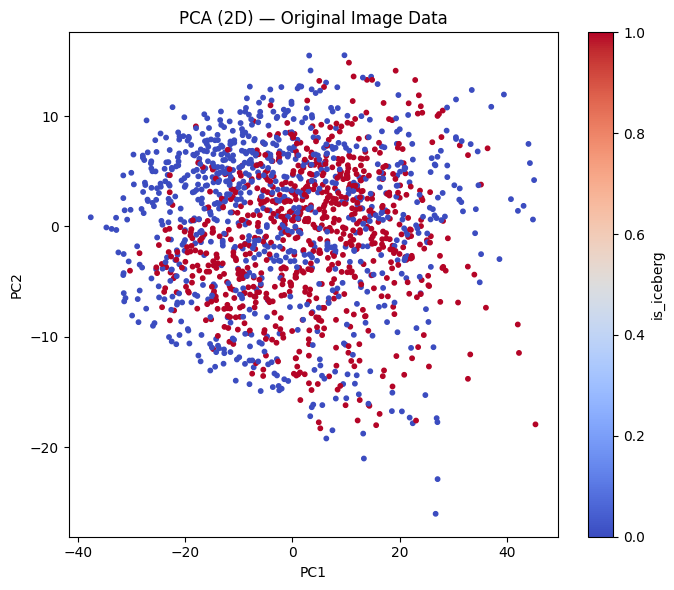

In [10]:
# ============================================================== 
# 2D PCA Visualization
# ==============================================================
pca_2d = PCA(n_components=2)
X_pca2 = pca_2d.fit_transform(X_flat)

plt.figure(figsize=(7, 6))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=y, cmap='coolwarm', s=10)
plt.title("PCA (2D) — Original Image Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="is_iceberg")
plt.tight_layout()
plt.show()


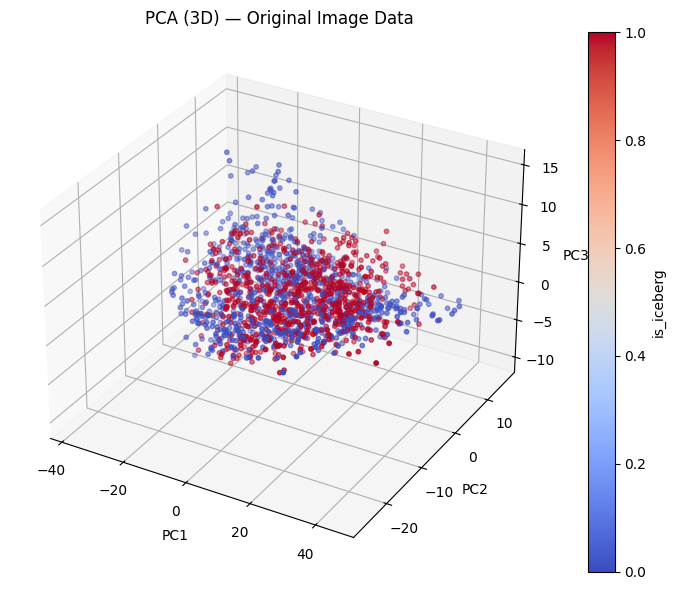

In [11]:
# ============================================================== 
# 3D PCA Visualization
# ==============================================================
pca_3d = PCA(n_components=3)
X_pca3 = pca_3d.fit_transform(X_flat)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2],
                c=y, cmap='coolwarm', s=10)
ax.set_title("PCA (3D) — Original Image Data")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
fig.colorbar(sc, label="is_iceberg")
plt.tight_layout()
plt.show()

In [12]:
print("Explained variance ratio (3 PCs):", pca_3d.explained_variance_ratio_)
print("Total variance captured (3 PCs):", pca_3d.explained_variance_ratio_.sum())

Explained variance ratio (3 PCs): [0.46882113 0.09126301 0.02089589]
Total variance captured (3 PCs): 0.5809800305381694
